In [1]:
import sqlite3
import pandas as pd
import os



In [3]:
pd.read_sql_query("PRAGMA table_info(df_encoded);", conn)


,cid,name,type,notnull,dflt_value,pk
0,0,provincia_x,TEXT,0,None,0
1,1,canton_id,INTEGER,0,None,0
2,2,nro_vivienda,REAL,0,None,0
3,3,tipo_via,INTEGER,0,None,0
4,4,tipo_vivienda,TEXT,0,None,0
...,...,...,...,...,...,...
220,220,deficit_habitacional_label_Dignas o aceptables,INTEGER,0,None,0
221,221,deficit_habitacional_label_Déficit cualitativo...,INTEGER,0,None,0
222,222,deficit_habitacional_label_Déficit cuantitativ...,INTEGER,0,None,0
223,223,registro_imputado_vivienda_label_No,INTEGER,0,None,0


In [13]:


# Connect to your database
conn = sqlite3.connect('/Users/dicordova/Proyecto-FDS/data/nueva_base.db')

query = "SELECT * FROM df_encoded LIMIT 5"
pd.read_sql_query(query, conn)

# Load the filtered data into a DataFrame
cotopaxi_df = pd.read_sql_query(query, conn)

# Preview the result
print(cotopaxi_df.head())

conn.close()


Empty DataFrame
Columns: [provincia_x, canton_id, nro_vivienda, tipo_via, tipo_vivienda, ocup_viv_part, ocup_viv_colect, mat_techo, estado_techo, mat_paredes, estado_paredes, mat_piso, estado_piso, tipo_agua, fuente_agua, tipo_sanitario, electricidad_red, otra_fuente_elec, eliminacion_basura, gasto_compartido, nro_hogares, zona_x, canton_x, id_vivienda_x, total_personas_x, ocup_viv_part_r, nro_cuartos_r, deficit_habitacional, registro_imputado_vivienda, mat_techo_labels, mat_techo_desc, provincia_y, nro_hogar, espacio_cocina, tiene_inodoro, tiene_ducha, combustible_cocina, fuente_agua_bebida, separa_basura_reciclaje, tiene_perros, tiene_gatos, tenencia_vivienda, tiene_telefono_fijo, tiene_celular, tiene_tv_pagada, tiene_internet, tiene_computadora, tiene_refrigeradora, tiene_lavadora, tiene_secadora, tiene_microondas, tiene_extractora_olores, tiene_auto, tiene_moto, fallecidos_ultimos_3_anios, emigrantes_desde_2010, nro_emigrantes, total_hombres, total_mujeres, zona_y, canton_y, id_hog

In [5]:
# Show all columns in output
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', True)

cols_info = pd.DataFrame({
    'column': cotopaxi_df.columns,
    'dtype': cotopaxi_df.dtypes.values
})
print(cols_info.sort_values(by='dtype'))


                                                column   dtype
0                                          provincia_x  object
142                              tipo_via_label_Pasaje  object
143                             tipo_via_label_Sendero  object
144      ocup_viv_part_label_De temporada o vacacional  object
145  ocup_viv_part_label_Ocupada con personas ausentes  object
..                                                 ...     ...
79   fuente_agua_bebida_label_La beben, tal como ll...  object
80   fuente_agua_bebida_label_La compran (agua enva...  object
81   fuente_agua_bebida_label_La filtran (colocan f...  object
111                            tiene_secadora_label_No  object
224                registro_imputado_vivienda_label_Sí  object

[225 rows x 2 columns]


In [6]:
with open('columns.txt', 'w') as f:
    for col in cotopaxi_df.columns:
        f.write(col + '\n')


Creamos un file de las columnas porque son muchas y el output sale truncado cada vez que intentamos explorarla para familiarizarnos con los nombres. 

In [7]:

# Create the summary DataFrame
col_info = pd.DataFrame({
    'Column Name': cotopaxi_df.columns,
    'Data Type': cotopaxi_df.dtypes.values,
    'Missing Values': cotopaxi_df.isna().sum().values
})

# Save it to a text file (tab-separated for readability)
col_info.to_csv('columns_info.txt', sep='\t', index=False)

# Optional: Preview in notebook
print(col_info)


                                           Column Name Data Type  \
0                                          provincia_x    object   
1                                            canton_id    object   
2                                         nro_vivienda    object   
3                                             tipo_via    object   
4                                        tipo_vivienda    object   
..                                                 ...       ...   
220     deficit_habitacional_label_Dignas o aceptables    object   
221  deficit_habitacional_label_Déficit cualitativo...    object   
222  deficit_habitacional_label_Déficit cuantitativ...    object   
223                registro_imputado_vivienda_label_No    object   
224                registro_imputado_vivienda_label_Sí    object   

     Missing Values  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
..              ...  
220               0  
221    

In [8]:
cols_a_remover = [col for col in cotopaxi_df.columns if (
    col.startswith('nro_cuartos_r_label_') or
    col.startswith('nro_emigrantes_label') or
    col.startswith('nro_hogar_label') or
    col.startswith('separa_basura') or
    col.startswith('fallecidos_ultimos_3_anios_label')
)]

cotopaxi_df = cotopaxi_df.drop(columns=cols_a_remover)


Después de sacar ciertas columnas, vamos a imputar los valores faltantes de las variables numéricas útiles para nuestro índice con KNN imputer. 

In [9]:
from sklearn.impute import KNNImputer

def imputar_knn_variables(cotopaxi_df, variables, n_neighbors=5):
    """
    Imputes missing values in the specified numerical columns using KNN.

    Parameters:
    - cotopaxi_df: pandas DataFrame
    - variables: list of column names to impute
    - n_neighbors: number of neighbors for KNNImputer (default: 5)

    Returns:
    - A DataFrame with the selected variables imputed.
    """
    cotopaxi_df = cotopaxi_df.copy()
    
    # Ensure all columns exist
    missing_cols = [col for col in variables if col not in cotopaxi_df.columns]
    if missing_cols:
        raise ValueError(f"The following columns are not in the DataFrame: {missing_cols}")
    
    # Apply KNN imputation
    imputer = KNNImputer(n_neighbors=n_neighbors)
    cotopaxi_df[variables] = imputer.fit_transform(cotopaxi_df[variables])
    
    return cotopaxi_df





In [10]:
variables_to_impute = [
    'nro_emigrantes',
    'total_personas_x',
    'nro_cuartos_r',
    'total_hombres',
    'total_mujeres'
]

cotopaxi_df = imputar_knn_variables(cotopaxi_df, variables_to_impute, n_neighbors=5)

ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by KNNImputer.

In [11]:
cotopaxi_df.shape


(0, 213)

Despues de la imputacion, vamos a sacar todos los valores NAN. Esta opcion se toma porque al haber imputado los valores ausentes en las variables numericas, podríamos usar el modo para las categóricas, pero no hay suficiente investigación para justificar esta decisión. Por lo tanto para el ejercicio las borraremos. 

In [10]:
cotopaxi_df_clean = cotopaxi_df.dropna().reset_index(drop=True)


Usamos KNN imputer para las variables numericas que usaremos en el modelo y en la construccion de variables compuestas. 

Creamos y combinamos varialbes en indicadores
Empezamos con hacinamiento. 

In [11]:
import numpy as np

# Evita división por cero o nulos
cotopaxi_df['personas_por_cuarto'] = cotopaxi_df['total_personas_x'] / cotopaxi_df['nro_cuartos_r']
import numpy as np

cotopaxi_df['personas_por_cuarto'] = cotopaxi_df['personas_por_cuarto'].replace([np.inf, -np.inf], np.nan)

# Crear categoría de hacinamiento
cotopaxi_df['hacinamiento'] = np.select(
    [
        cotopaxi_df['personas_por_cuarto'] <= 2,
        (cotopaxi_df['personas_por_cuarto'] > 2) & (cotopaxi_df['personas_por_cuarto'] < 4),
        cotopaxi_df['personas_por_cuarto'] >= 4
    ],
    ['Aceptable', 'Moderado', 'Severo'],
    default='Desconocido'
)

print(cotopaxi_df['personas_por_cuarto'].value_counts())



personas_por_cuarto
1.000000     32849
2.000000     14061
0.500000     10702
1.500000      9082
0.666667      8662
             ...  
14.000000        1
5.333333         1
4.400000         1
6.333333         1
3.600000         1
Name: count, Length: 72, dtype: int64


In [12]:
print(cotopaxi_df['hacinamiento'].unique())

['Aceptable' 'Moderado' 'Severo']


In [13]:
hacinamiento_map = {'Aceptable': 0, 'Moderado': 1, 'Severo': 2, 'Desconocido': np.nan}
cotopaxi_df['hacinamiento_score'] = cotopaxi_df['hacinamiento'].map(hacinamiento_map)
print(cotopaxi_df[['hacinamiento', 'hacinamiento_score']].head(10))

  hacinamiento  hacinamiento_score
0    Aceptable                 0.0
1    Aceptable                 0.0
2    Aceptable                 0.0
3    Aceptable                 0.0
4    Aceptable                 0.0
5    Aceptable                 0.0
6     Moderado                 1.0
7    Aceptable                 0.0
8    Aceptable                 0.0
9    Aceptable                 0.0


In [14]:
# Definir las columnas que indican vulnerabilidad
cols_vulnerables = [
    # Materiales precarios
    'mat_techo_label_Palma, paja u hoja',
    'mat_techo_label_Otro material',
    'mat_paredes_label_Caña no revestida',
    'mat_paredes_label_Adobe o tapia',
    'mat_paredes_label_Otro material',
    'mat_piso_label_Tierra',
    'mat_piso_label_Caña sin tratar',
    'mat_piso_label_Otro material',

    # Estados "Malos"
    'estado_techo_label_Malo',
    'estado_paredes_label_Malo',
    'estado_piso_label_Malo',

    # Ocupación inestable
    'ocup_viv_part_label_De temporada o vacacional',
    'ocup_viv_part_label_Ocupada con personas ausentes',
    'ocup_viv_colect_label_Sin residentes habituales'
]

# Asegurarnos de que las columnas existen
cols_vulnerables = [col for col in cols_vulnerables if col in cotopaxi_df.columns]

# Sumar como score
cotopaxi_df['vulnerabilidad_vivienda'] = cotopaxi_df[cols_vulnerables].sum(axis=1)


In [15]:
cotopaxi_df['nivel_vulnerabilidad_vivienda'] = pd.cut(
    cotopaxi_df['vulnerabilidad_vivienda'],
    bins=[-1, 1, 3, 5, np.inf],
    labels=['Baja', 'Media-baja', 'Media-alta', 'Alta']
)
print(cotopaxi_df[['vulnerabilidad_vivienda', 'nivel_vulnerabilidad_vivienda']].head(10))

   vulnerabilidad_vivienda nivel_vulnerabilidad_vivienda
0                        0                          Baja
1                        0                          Baja
2                        0                          Baja
3                        0                          Baja
4                        0                          Baja
5                        0                          Baja
6                        0                          Baja
7                        0                          Baja
8                        0                          Baja
9                        2                    Media-baja


In [16]:
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean.reset_index(drop=True)

cotopaxi_df_clean = remove_outliers_iqr(cotopaxi_df, ['vulnerabilidad_vivienda', 'personas_por_cuarto', 'hacinamiento_score'])


In [17]:
print("Antes de remover outliers:", cotopaxi_df.shape)
print("Después de remover outliers:", cotopaxi_df_clean.shape)


Antes de remover outliers: (139362, 231)
Después de remover outliers: (112114, 231)


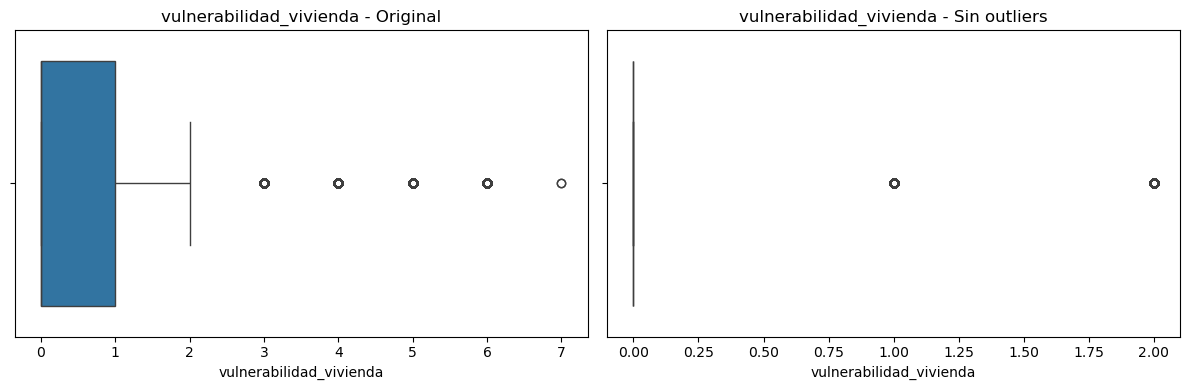

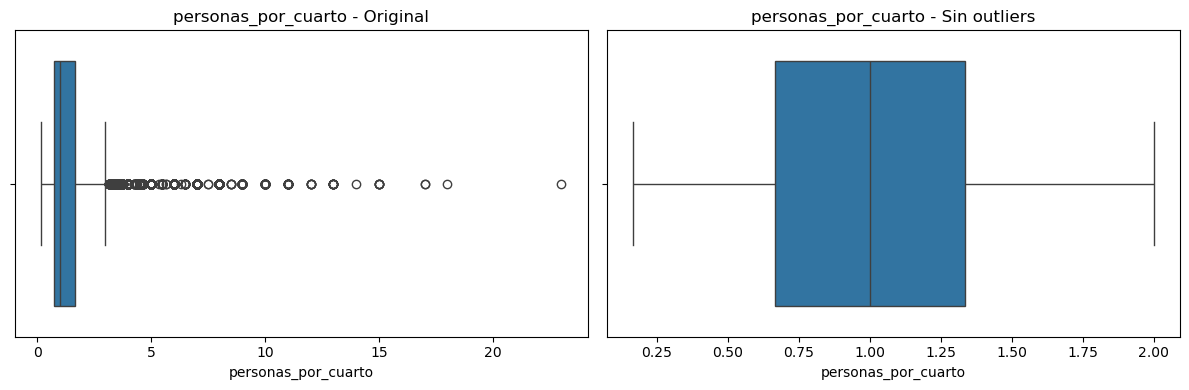

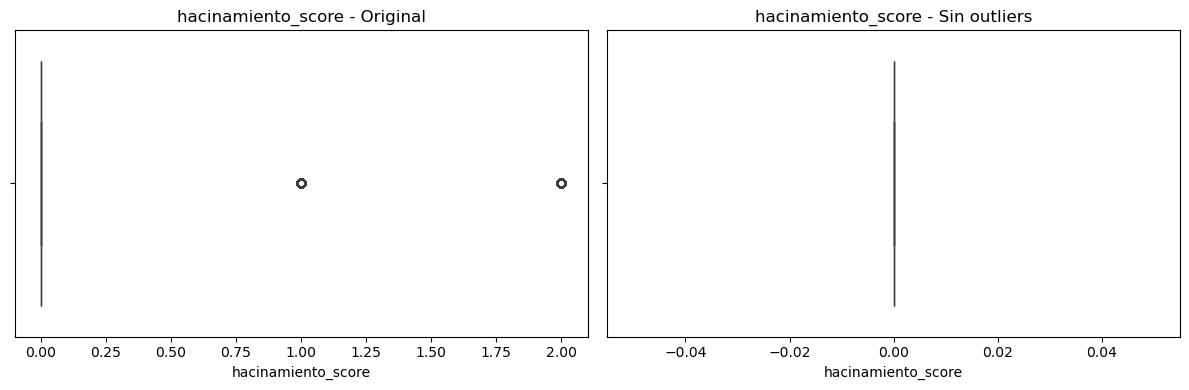

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

variables = ['vulnerabilidad_vivienda', 'personas_por_cuarto', 'hacinamiento_score']

for var in variables:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.boxplot(x=cotopaxi_df[var], ax=axes[0])
    axes[0].set_title(f'{var} - Original')

    sns.boxplot(x=cotopaxi_df_clean[var], ax=axes[1])
    axes[1].set_title(f'{var} - Sin outliers')

    plt.tight_layout()
    plt.show()


In [38]:
cotopaxi_df_clean.to_csv('/Users/dicordova/Proyecto-FDS/data/cotopaxi_df_clean.csv', index=False)


Esta transformación se hizo para: 
Para resumir vulnerabilidad en 4 niveles simples.

Para visualización (gráficos de barras, mapas coropléticos).

Para perfilar clusters usando métodos no supervisados.

In [39]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('/Users/dicordova/Proyecto-FDS/data/nueva_base.db')

cotopaxi_df_clean.to_sql('cotopaxi_df_clean', conn, if_exists='replace', index=False)

conn.close()

In [20]:
# from sklearn.preprocessing import StandardScaler

# # Selecciona las variables que representan vulnerabilidad
# variables_cluster = [
#     'vulnerabilidad_vivienda',
#     'personas_por_cuarto'
#     #'hacinamiento_score'
# ]

# # Escalar los datos
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(cotopaxi_df_clean[variables_cluster])
# X_scaled  # Muestra las primeras 5 filas del array escalado

In [21]:
# cotopaxi_df_clean[variables_cluster]
# cotopaxi_df_clean['hacinamiento_score'].value_counts()

In [22]:
# X_scaled_df = pd.DataFrame(X_scaled, columns=variables_cluster, index=cotopaxi_df_clean.index)


In [23]:
# from sklearn.cluster import KMeans

# # Inicializa KMeans con 4 clusters
# kmeans = KMeans(n_clusters=4, random_state=42, max_iter=300)
# kmeans.fit(cotopaxi_df_clean[variables_cluster])
# cotopaxi_df_clean['cluster_kmeans'] = kmeans.labels_

In [24]:
# #Evaluamos los cluster
# cotopaxi_df_clean.groupby('cluster_kmeans')[variables_cluster].mean().round(2)


Cluster	Vulnerabilidad Vivienda	Personas por Cuarto	Interpretación

0	0.0	0.73	Vivienda estable, poco hacinamiento ✅

1	2.0	1.20	Alta vulnerabilidad en vivienda ⚠️

2	0.0	1.58	Vivienda buena, pero muy hacinados 🔥

3	1.0	1.15	Vulnerabilidad media, hacinamiento moderado



In [25]:
# from sklearn.cluster import AgglomerativeClustering

# agglo = AgglomerativeClustering(n_clusters=4)
# cotopaxi_df_clean['cluster_agglo'] = agglo.fit_predict(X_scaled)


In [26]:
# #evaluamos los cluster
# cotopaxi_df_clean.groupby('cluster_agglo')[variables_cluster].mean().round(2)


Cluster	Vulnerabilidad Vivienda	Personas por Cuarto	Interpretación

0	1.13	1.15	Mixto, media vulnerabilidad 🟠

1	0.00	1.19	Vivienda buena, hacinamiento leve ✅

2	0.00	0.55	Vivienda buena, poco hacinamiento 🟢

3	0.00	2.00	Vivienda buena, pero severamente hacinados 🔴

In [27]:
# from sklearn.cluster import MiniBatchKMeans
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# # Suponiendo que ya tienes X_scaled (si no, escálalo así):
# # scaler = StandardScaler()
# # X_scaled = scaler.fit_transform(cotopaxi_df_clean[variables_cluster])

# # MiniBatchKMeans con 4 clusters
# mb_kmeans = MiniBatchKMeans(n_clusters=4, random_state=42, batch_size=1000)
# mb_kmeans.fit(X_scaled)

# # Guardamos etiquetas
# cotopaxi_df_clean['cluster_minibatch'] = mb_kmeans.labels_


In [28]:
# #evaluamos los cluster
# cotopaxi_df_clean.groupby('cluster_minibatch')[variables_cluster].mean().round(2)

Cluster	Vulnerabilidad Vivienda	Personas por Cuarto	Interpretación resumida

0	1.50	1.82	Alta vulnerabilidad y hacinamiento grave 🔥

1	0.00	1.32	Vivienda adecuada, pero con cierto hacinamiento ⚠️

2	1.09	1.08	Vulnerabilidad media, hacinamiento moderado 🟠

3	0.00	0.55	Vivienda adecuada y poco hacinamiento ✅

Cluster 0 probablemente concentra a las familias en mayor situación de riesgo: malas condiciones de vivienda y muchas personas por cuarto.

Cluster 3 parece ser el más seguro o resiliente.

Cluster 1 muestra hacinamiento con vivienda aceptable, algo interesante: podrían ser hogares informales o con dinámicas familiares complejas.

Cluster 2 está en el centro, un mix.

In [29]:
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# # Reducimos a 2 dimensiones para graficar
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_scaled)

# # Añadir coordenadas PCA al DataFrame para trazarlos
# cotopaxi_df_clean['PCA1'] = X_pca[:, 0]
# cotopaxi_df_clean['PCA2'] = X_pca[:, 1]


In [30]:
# plt.figure(figsize=(8,6))
# plt.scatter(cotopaxi_df_clean['PCA1'], cotopaxi_df_clean['PCA2'], 
#             c=cotopaxi_df_clean['cluster_kmeans'], cmap='viridis', s=50)
# plt.title('Clusters KMeans')
# plt.xlabel('PCA1')
# plt.ylabel('PCA2')
# plt.grid(True)
# plt.show()


Del gráfico podemos concluir: 
Cuando hago PCA, estoy transformando mis datos multivariados a un nuevo sisstema de coordinadas, que resume la mayor cantidad de variabilidad en pocas dimensiones. Aquí se indica que los clusters están bien separados en el espacio PCA, es decir no hay solapación en los grupos. Hay una estructural natural en los grupos que Kmeans parece haber capturado bien. 

Esto puede deberse gracias a que: 
Las variables tienen una relación continua (como pobreza o hacinamiento) o cuando hay un patrón jerárquico entre observaciones

In [31]:
# plt.figure(figsize=(8,6))
# plt.scatter(cotopaxi_df_clean['PCA1'], cotopaxi_df_clean['PCA2'], 
#             c=cotopaxi_df_clean['cluster_agglo'], cmap='plasma', s=50)
# plt.title('Clusters Agglomerative')
# plt.xlabel('PCA1')
# plt.ylabel('PCA2')
# plt.grid(True)
# plt.show()


Del gráfico podemos concluir que: 
Los clusters están más desequilibrados comparados con los de KMeans

Un color (azul oscuro) parece agrupar a la mayoría de los puntos. Otros clusters (amarillo brillante, morado, rosado) tienen muy pocos elementos. El cluster amarillo parece ser un outlier solitario → probablemente una observación única y muy distinta.

Tiende a formar clusters jerárquicos, lo que a veces agrupa muchos puntos en uno grande y deja pocos pequeños.

Es sensible a la escala y a la densidad

In [32]:
# # Reducimos a 2D para graficar
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_scaled)

# cotopaxi_df_clean['PCA1'] = X_pca[:, 0]
# cotopaxi_df_clean['PCA2'] = X_pca[:, 1]

# # Plot
# plt.figure(figsize=(8,6))
# plt.scatter(cotopaxi_df_clean['PCA1'], cotopaxi_df_clean['PCA2'],
#             c=cotopaxi_df_clean['cluster_minibatch'], cmap='tab10', s=50)
# plt.title('Clusters con MiniBatch KMeans')
# plt.xlabel('PCA1')
# plt.ylabel('PCA2')
# plt.grid(True)
# plt.show()


Del gráfico podemos concluir que: 

Visualmente, puedes decir que hay al menos 4 poblaciones distintas en cuanto a vulnerabilidad (por ejemplo: alto hacinamiento y mala vivienda vs. baja vulnerabilidad).

In [33]:
# mapa_labels = {
#     0: 'Crítico',
#     1: 'Moderado: hacinamiento con vivienda adecuada',
#     2: 'Vulnerabilidad media',
#     3: 'Condiciones adecuadas'
# }


In [34]:
# cotopaxi_df_clean['perfil_minibatch'] = cotopaxi_df_clean['cluster_minibatch'].map(mapa_labels)


In [35]:
# cotopaxi_df_clean['perfil_minibatch'].value_counts()


In [36]:
# import matplotlib.pyplot as plt

# # Contar cuántos hay por perfil
# conteo_perfiles = cotopaxi_df_clean['perfil_minibatch'].value_counts()

# # Crear gráfico de barras
# plt.figure(figsize=(10,6))
# conteo_perfiles.plot(kind='bar', color='skyblue', edgecolor='black')

# plt.title('Distribución de Perfiles de Vulnerabilidad (MiniBatchKMeans)', fontsize=14)
# plt.xlabel('Perfil de Vulnerabilidad', fontsize=12)
# plt.ylabel('Número de Observaciones', fontsize=12)
# plt.xticks(rotation=45, ha='right')
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# plt.tight_layout()
# plt.show()


Al comparar los tres modelos parece ser mejor al MiniBatchKmeans. En este caso no tenemos métricas como en los modelos de regresión, sin embargo este modelo nos permite: 
Escalar a millones de datos (necesario, dado que el censo tienen al menos 3millones de datos para las 5 provincias que están involucradas)

Identifica poblaciones altamente vulnerables al detectar los perfiles de cluster como el número de personas por habitación o vulnerabilidades de vivienda. 

Sin embargo, el modelo de Agglomerative mostró sensibilidad ante los outliers. Es decir, podría ser usado en muestras de datos más pequeñas que permitan reafinar perfiles e identificar la vulnerabilidad por zonas geográficas más pequeñas. Es decir, en lugar de decir "la provincia de Cotopaxi es vulnerable" podemos decir, la Provincia de Cotopaxi, en la ciudad de Latacunga y su cantón X tiene una granconcentración de viviendas/hogares vulnerables" lo que es precisamente más útil al momento de diseñar política pública. 

Esto es importante tomar en cuenta para poder hacer un mapeo de los clusters. Algo que podría hacerse en un paso posterior. 